In [7]:
import pandas as pd 
import polars as pl
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

df1 = pd.read_csv('/Users/ghaliabennani/Desktop/financial_big_data/data/combined_stock_data1.csv')
df2 = pd.read_csv('/Users/ghaliabennani/Desktop/financial_big_data/data/combined_stock_data.csv')
df3 = pd.read_csv('/Users/ghaliabennani/Desktop/financial_big_data/data/combined_stock_data2.csv')

# Combine the DataFrames
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

In [8]:
combined_df.head()

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock
0,2010-05-03 09:30:00-04:00,58.960000,6.0,35.0,59.065455,11.0,2.0,59.030000,1200.0,2010-05-03,NaN,NaN,NaN,DLR
1,2010-05-03 09:32:00-04:00,59.028846,5.0,26.0,59.143333,12.0,2.0,59.103284,1218.0,2010-05-03,2.0,0.001241,0.000621,DLR
2,2010-05-03 09:33:00-04:00,59.304444,4.0,9.0,59.555000,10.0,3.0,59.518000,500.0,2010-05-03,1.0,0.007017,0.007017,DLR
3,2010-05-03 09:34:00-04:00,59.560000,1.0,2.0,59.660000,4.0,2.0,59.560000,400.0,2010-05-03,1.0,0.000706,0.000706,DLR
4,2010-05-03 09:35:00-04:00,59.570000,1.0,1.0,59.710000,5.0,5.0,59.680000,100.0,2010-05-03,1.0,0.002015,0.002015,DLR


In [9]:
# Apply the function to your data

def calculate_market_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Aggregate stock data into market-level features for each minute.
    
    Parameters:
    - df: Polars DataFrame containing stock data with necessary columns.
    
    Returns:
    - market_data: Polars DataFrame with aggregated market-level features.
    """
    market_data = (
        df.group_by('minute')
        .agg([
            # Price volatility (standard deviation of weighted trade prices)
            pl.col('weighted_trade_price').std().alias('price_volatility'),

            # Return volatility (volume-weighted standard deviation of returns)
            (
                (pl.col('return') * pl.col('total_trade_volume'))
                .sum()
                / pl.col('total_trade_volume').sum()
            ).alias('avg_return'),
            pl.col('return').std().alias('return_volatility'),

            

            # Trade volume statistics
            pl.col('total_trade_volume').mean().alias('avg_trade_volume'),
            pl.col('total_trade_volume').std().alias('volume_volatility'),

            # Average bid-ask spread
            ((pl.col('weighted_ask_price') - pl.col('weighted_bid_price')).mean())
            .alias('avg_spread'),

            # Proportion of advancing stocks (positive returns)
            (pl.col('return') > 0).mean().alias('advancing_stocks'),
        ])
        .fill_null(0)  # Replace null values with 0
    )

    # Ensure the results are sorted by minute
    market_data = market_data.sort('minute')

    return market_data


In [10]:
combined_df = pl.DataFrame(combined_df)
market_data = calculate_market_data(combined_df)

In [11]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from community import community_louvain

def create_windowed_clustering_polars(df, window=390, threshold=0.5):
    """
    Perform clustering within each rolling window, compute cluster characteristics,
    and suggest a trading strategy for the last element in the window.
    Also, compute the average market data within each window and ensure a valid cluster for the last element.

    Parameters:
        df (pl.DataFrame): Input data containing market features.
        window (int): Size of the rolling window.
        threshold (float): Minimum similarity value for the sparse similarity matrix.

    Returns:
        pl.DataFrame: Dataframe containing cluster characteristics, average market data,
                      transition matrices, last element's cluster, and trading strategies for each window.
    """
    results = []

    for start in range(len(df) - window + 1):
        # Define the rolling window
        window_df = df.slice(start, window)

        # Extract features for clustering
        clustering_features = [
            'price_volatility',
            'return_volatility',
            'avg_return',
            'avg_trade_volume',
            'volume_volatility',
            'advancing_stocks',
            'avg_spread'
        ]
        features = window_df.select(clustering_features).to_numpy()

        # Normalize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Compute similarity matrix
        similarity = cosine_similarity(features_scaled)
        np.fill_diagonal(similarity, 0)  # Avoid self-loops

        # Create graph based on the similarity matrix
        G = nx.Graph()
        for i in range(len(features_scaled)):
            G.add_node(i)  # Add all nodes, even if no edges exist

        for i in range(len(similarity)):
            for j in range(i + 1, len(similarity)):
                if similarity[i, j] > threshold:
                    G.add_edge(i, j, weight=similarity[i, j])

        # Perform Louvain clustering on the graph
        partition = community_louvain.best_partition(G, weight='weight')

        # Ensure all nodes have a cluster
        for node in G.nodes:
            if node not in partition:
                # Assign to the nearest cluster
                closest_node = max(
                    ((other_node, similarity[node, other_node]) for other_node in G.nodes if node != other_node),
                    key=lambda x: x[1],
                    default=(None, None)
                )[0]
                if closest_node is not None:
                    partition[node] = partition[closest_node]

        # Map clusters to the window DataFrame
        cluster_assignments = [partition[i] for i in range(len(window_df))]
        window_df = window_df.with_columns(pl.Series("cluster", cluster_assignments))

        # Compute cluster characteristics
        cluster_characteristics = []
        for cluster_id in set(partition.values()):
            cluster_data = window_df.filter(pl.col("cluster") == cluster_id)
            stats = {
                'cluster': cluster_id,
                'mean_return': cluster_data.select(pl.col('avg_return')).mean()[0, 0],
                'std_return': cluster_data.select(pl.col('avg_return')).std()[0, 0],
                'mean_volatility': cluster_data.select(pl.col('return_volatility')).mean()[0, 0],
                'avg_trade_volume': cluster_data.select(pl.col('avg_trade_volume')).mean()[0, 0],
                'avg_spread': cluster_data.select(pl.col('avg_spread')).mean()[0, 0],
                'size': cluster_data.height,
            }
            cluster_characteristics.append(stats)

        # Determine the cluster of the last element in the window
        last_element_cluster = window_df[-1, "cluster"]
        last_cluster_stats = next(
            (char for char in cluster_characteristics if char['cluster'] == last_element_cluster),
            None
        )

        # Compute average market data for the window
        avg_market_data = {
            'avg_price_volatility': window_df.select(pl.col('price_volatility')).mean()[0, 0],
            'avg_return_volatility': window_df.select(pl.col('return_volatility')).mean()[0, 0],
            'avg_return': window_df.select(pl.col('avg_return')).mean()[0, 0],
            'avg_trade_volume': window_df.select(pl.col('avg_trade_volume')).mean()[0, 0],
            'avg_advancing_stocks': window_df.select(pl.col('advancing_stocks')).mean()[0, 0],
            'avg_spread': window_df.select(pl.col('avg_spread')).mean()[0, 0],
        }

        # Store results for the window
        results.append({
            'start_time': window_df[0, "minute"],
            'end_time': window_df[-1, "minute"],
            'cluster_assignments': window_df.select(['minute', 'cluster']).to_dicts(),
            'cluster_characteristics': cluster_characteristics,
            'average_market_data': avg_market_data,
            'last_element_cluster': last_element_cluster
        })

    # Convert results into a Polars DataFrame
    final_df = pl.DataFrame(results)
    return final_df


In [ ]:
# Apply the function to the market data
#ignore warnings 
import warnings
warnings.filterwarnings('ignore')







windowed_results = create_windowed_clustering_polars(market_data, window=780, threshold=0.5)


In [5]:
def apply_strategy(merged_data):
    """
    Apply a trading strategy using the given market data and cluster characteristics.

    Parameters:
        merged_data (pd.DataFrame): Input DataFrame containing market data and cluster characteristics.

    Returns:
        pd.DataFrame: DataFrame with trading actions, positions, and cumulative returns.
    """
    trading_results = []
    current_position = 0  # Initial position (0: none, +1: long, -1: short)
    cumulative_return = 0  # Tracks cumulative strategy return

    for _, row in merged_data.iterrows():
        last_cluster = row["last_element_cluster"]
        
        # Use `cluster_characteristics` and `average_market_data` directly
        cluster_characteristics = row["cluster_characteristics"]
        market_data_avg = row["average_market_data"]

        # Retrieve cluster data for the last element's cluster
        cluster_data = next((char for char in cluster_characteristics if char["cluster"] == last_cluster), None)
        if not cluster_data:
            continue  # Skip if no cluster data is found

        # Extract metrics
        cluster_mean_return = cluster_data["mean_return"]
        cluster_mean_volatility = cluster_data["mean_volatility"]
        cluster_avg_spread = cluster_data["avg_spread"]

        market_mean_return = market_data_avg["avg_return"]
        market_mean_volatility = market_data_avg["avg_return_volatility"]
        market_avg_spread = market_data_avg["avg_spread"]

        # Strategy logic
        action = "Hold"  # Default action
        position_change = 0

        if current_position == 0:  # No position
            if cluster_mean_return > market_mean_return + 0.5 * market_mean_volatility and cluster_avg_spread < market_avg_spread:
                action = "Buy"
                position_change = 1
            elif cluster_mean_return < market_mean_return - 0.5 * market_mean_volatility and cluster_avg_spread < market_avg_spread:
                action = "Sell"
                position_change = -1
        elif current_position == 1:  # Long position
            if cluster_mean_return < market_mean_return - 0.75 * market_mean_volatility:
                action = "Sell to Short"
                position_change = -2
            elif cluster_avg_spread > market_avg_spread + 0.01:
                action = "Close Position"
                position_change = -1
        elif current_position == -1:  # Short position
            if cluster_mean_return > market_mean_return + 0.75 * market_mean_volatility:
                action = "Buy to Long"
                position_change = 2
            elif cluster_avg_spread > market_avg_spread + 0.01:
                action = "Close Position"
                position_change = 1

        # Calculate returns
        last_avg_return = row["avg_return"]
        strategy_return = current_position * last_avg_return
        cumulative_return += strategy_return

        # Update current position
        current_position += position_change

        # Store results
        trading_results.append({
            "start_time": row["start_time"],
            "end_time": row["end_time"],
            "action": action,
            "position": current_position,
            "strategy_return": strategy_return,
            "cumulative_return": cumulative_return,
            "last_element_cluster": last_cluster,
            "cluster_data": cluster_data,
            "market_data_avg": market_data_avg,
            "last_avg_return": last_avg_return
        })

    return pd.DataFrame(trading_results)

# Example Usage
# strategy_results = apply_strategy(merged_data)


In [6]:
market_data_pd = market_data.to_pandas()

In [7]:
windowed_results_pd = windowed_results.copy()
#windowed_results_pd = windowed_results.to_pandas()

In [9]:
merged_data = pd.merge(windowed_results_pd, market_data_pd, left_on="end_time", right_on="minute", how="inner")

In [10]:
merged_data= merged_data.drop(columns=['minute'])

In [15]:
import pandas as pd
import ast

# Function to preprocess the data
def preprocess_data_for_strat(merged_data):
    """
    Fix formatting issues and ensure columns contain valid Python objects.
    """
    def fix_format(value):
        if isinstance(value, (list, dict)):
            return value  # Already a valid object
        try:
            # Replace newlines with commas for valid syntax
            formatted_value = value.replace("\n", ", ")
            return ast.literal_eval(formatted_value)
        except Exception as e:
            raise ValueError(f"Cannot parse the value: {value}. Error: {e}")
    
    # Apply to columns with potential formatting issues
    merged_data["cluster_characteristics"] = merged_data["cluster_characteristics"].apply(fix_format)
    merged_data["average_market_data"] = merged_data["average_market_data"].apply(fix_format)
    return merged_data

# Apply preprocessing
merged_data = preprocess_data_for_strat(merged_data)

# Now, apply the strategy
strategy_results = apply_strategy(merged_data)


In [17]:
# Save the results to a CSV file
strategy_results.to_csv('/Users/othmaneio/Documents/financial_big_data/strategy_results.csv', index=False)

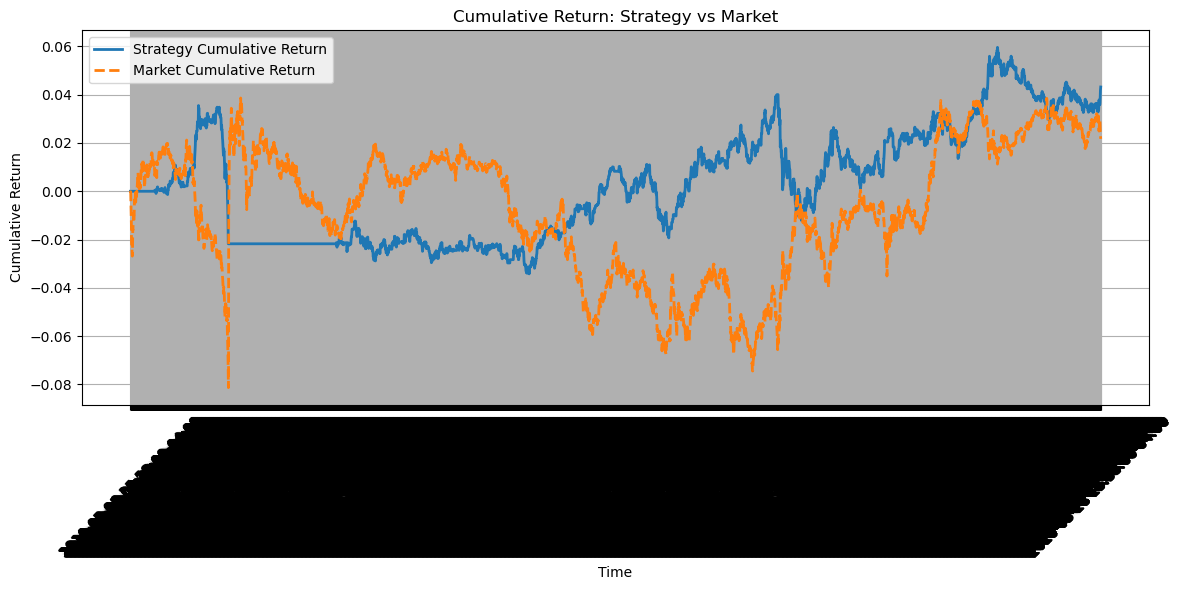

In [24]:
#plot the cumulative return vs market cumulative return
import matplotlib.pyplot as plt

def plot_cumulative_returns(strategy_results, merged_data):
    """
    Plot the cumulative returns of the strategy versus the market's cumulative returns.

    Parameters:
        strategy_results (pd.DataFrame): DataFrame containing strategy cumulative returns.
        merged_data (pd.DataFrame): Original merged market data for calculating market cumulative returns.
    """
    # Calculate market cumulative return
    merged_data["market_cumulative_return"] = merged_data["avg_return"].cumsum()

    # Extract strategy cumulative return
    strategy_cumulative_return = strategy_results["cumulative_return"]

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(strategy_results["end_time"], strategy_cumulative_return, label="Strategy Cumulative Return", linewidth=2)
    plt.plot(merged_data["end_time"], merged_data["market_cumulative_return"], label="Market Cumulative Return", linestyle="--", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Return: Strategy vs Market")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ensure the strategy results and market data are processed
plot_cumulative_returns(strategy_results, merged_data)



In [52]:
#save windowed_results to csv

windowed_results.to_pandas().to_csv('/Users/othmaneio/Documents/financial_big_data/windowed_results.csv')

Parsed cluster data shape: (780, 2)
Merged data shape: (780, 9)
Number of unique clusters: 4


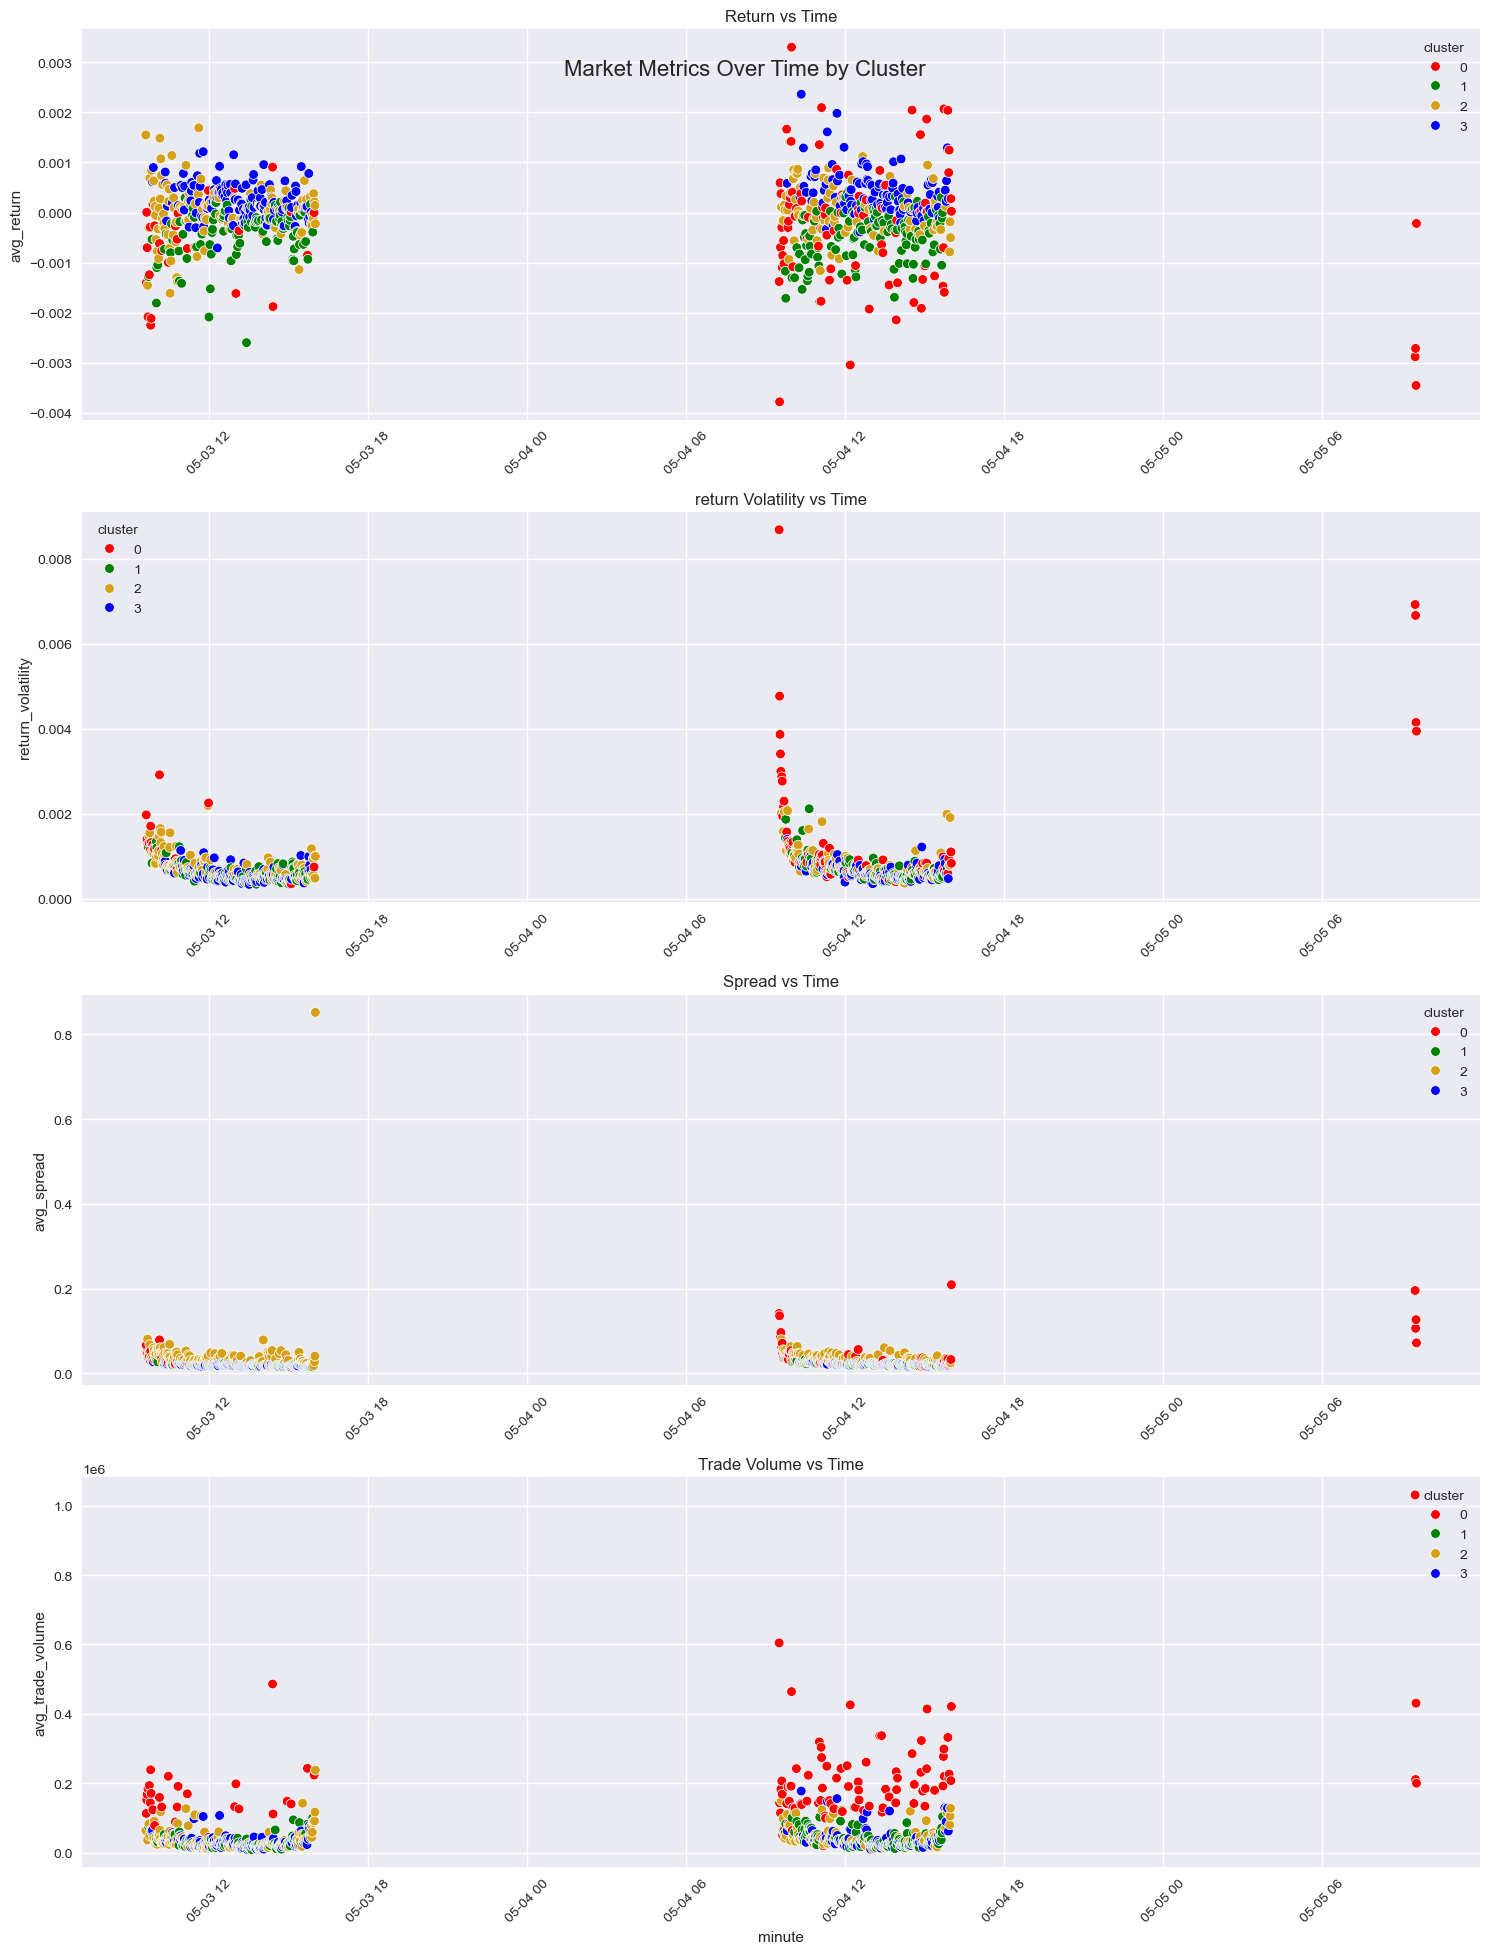

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def parse_cluster_data(cluster_assignments_str):
    # Clean up the string and add missing commas
    cleaned_str = cluster_assignments_str.strip('[]')
    cleaned_str = re.sub(r'}\s*{', '}, {', cleaned_str)
    cluster_data = eval('[' + cleaned_str + ']')
    return pd.DataFrame(cluster_data)

def plot_market_metrics(market_df, cluster_assignments):
    # Set the style
    plt.style.use('seaborn')
    # Create color palette for clusters
    

    
    # Create a figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    fig.suptitle('Market Metrics Over Time by Cluster', fontsize=16, y=0.95)
    
    # Create color palette for clusters
    n_clusters = len(set(cluster_assignments['cluster']))
    # Create color palette for clusters
    # Create color palette for clusters (Red, Green, Yellow, Blue)
    # Create color palette with mustard yellow
    colors = sns.color_palette(["red", "green", "#D4A017", "blue"])  # #D4A017 is mustard yellow



    
    # Convert timestamps to datetime
    cluster_assignments['minute'] = pd.to_datetime(cluster_assignments['minute'])
    market_df['minute'] = pd.to_datetime(market_df['minute'])
    
    # Merge market data with cluster assignments
    merged_data = pd.merge(market_df, cluster_assignments, on='minute', how='inner')
    
    print("Merged data shape:", merged_data.shape)
    print("Number of unique clusters:", merged_data['cluster'].nunique())
    
    # Plot Return vs Time
    sns.scatterplot(data=merged_data, 
                   x='minute',
                   y='avg_return',
                   hue='cluster',
                   palette=colors,
                   ax=axes[0])
    axes[0].set_title('Return vs Time')
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot Volatility vs Time
    sns.scatterplot(data=merged_data,
                   x='minute',
                   y='return_volatility',
                   hue='cluster',
                   palette=colors,
                   ax=axes[1])
    axes[1].set_title('return Volatility vs Time')
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Plot Spread vs Time
    sns.scatterplot(data=merged_data,
                   x='minute',
                   y='avg_spread',
                   hue='cluster',
                   palette=colors,
                   ax=axes[2])
    axes[2].set_title('Spread vs Time')
    axes[2].set_xlabel('')
    axes[2].tick_params(axis='x', rotation=45)
    
    # Plot Volume vs Time
    sns.scatterplot(data=merged_data,
                   x='minute',
                   y='avg_trade_volume',
                   hue='cluster',
                   palette=colors,
                   ax=axes[3])
    axes[3].set_title('Trade Volume vs Time')
    axes[3].tick_params(axis='x', rotation=45)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig

# Main execution
def main():
    # Parse cluster assignments
    cluster_df = parse_cluster_data(windowed_results_pd.iloc[6]['cluster_assignments'])
    print("Parsed cluster data shape:", cluster_df.shape)
    
    # Ensure market_data has the right column names
    if 'minute' not in market_data_pd.columns:
        print("Available columns in market_data:", market_data_pd.columns)
        # If minute is the index, reset it to be a column
        market_data_pd.reset_index(inplace=True)
        market_data_pd.rename(columns={'index': 'minute'}, inplace=True)
    
    # Ensure numeric columns are float
    numeric_columns = ['price_volatility', 'avg_return', 'return_volatility', 
                      'avg_trade_volume', 'volume_volatility', 'avg_spread', 'advancing_stocks']
    for col in numeric_columns:
        if col in market_data_pd.columns:
            market_data_pd[col] = pd.to_numeric(market_data_pd[col], errors='coerce')
    
    # Create and show the plot
    fig = plot_market_metrics(market_data_pd, cluster_df)
    plt.show()

if __name__ == "__main__":
    main()